## 8. Batch Normalization (배치 정규화)

- 은닉층(hidden layer)이 많아질수록 **validation loss가 줄지 않는 문제**가 발생할 수 있음
    
    ⇒ 특히 `tanh`나 `sigmoid` 같은 활성화 함수의 양 끝에 값이 몰릴 경우 **기울기 소실(vanishing gradient)** 문제가 생김
    
- 이 문제를 완화하기 위해 **정규화를 통해 입력 분포를 조정**함
    
    ⇒ 미니배치 단위로 각 특성(feature, x₁, x₂, ...)의 평균과 분산을 계산해 정규화 수행
    
- 모든 layer에 **항상 평균 0, 분산 1의 입력만 들어오면**, 각 층에서 표현할 수 있는 정보가 제한되어 **모델이 충분히 학습하지 못할 수 있음**
    - 따라서 정규화 후 **γ, β** 같은 파라미터를 도입해, **정규분포를 학습 가능한 형태로 조정**할 수 있도록 함
    
    ⇒ 이는 **표현력 확보**와 **유연한 분포 조정**을 동시에 가능하게 함
    
- 정규화 수식은 다음과 같음:

$$
\mu_B = \frac{1}{m} \sum_{i=1}^{m} x_i

$$

$$
\sigma_B^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2
$$

$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$

$$
y_i = \gamma \hat{x}_i + \beta
$$

- 정규화는 **활성화 함수 적용 전에 수행** 하며, 이 과정에서 bias 항(term)의 역할이 사라짐
    
    ⇒ **bias는 정규화 과정에서 평균 제거로 인해 효과가 없어지므로, 생략해도 됨(bias = False)**
    
- test 환경에서는 **배치 크기가 작거나 or 데이터가 랜덤하지 않고 편향될 가능성**이 있음(**하나의 샘플**이나 **작은 배치 크기**로 예측하는 경우가 많음)
    
    ⇒ 이 경우 **계산한 배치 평균/분산은 신뢰할 수 없음**
    
- 따라서, **학습 중의 평균/분산 정보를 미리 저장**해두고 사용하는 방식 필요
    
    ⇒ Moving Average(지수 이동 평균)를 통해 **안정적인 추론을 보장**
    
    $$
    \mu_{\text{moving}} \leftarrow \rho \cdot \mu_{\text{moving}} + (1 - \rho) \cdot \mu_{\text{batch}}
    $$
    
    $$
    \sigma^2_{\text{moving}} \leftarrow \rho \cdot \sigma^2_{\text{moving}} + (1 - \rho) \cdot \sigma^2_{\text{batch}}
    
    $$
    
    ⇒ 테스트할 땐 새로운 배치의 평균과 분산을 **계산하지 않고**, **학습 시 저장해둔 moving 평균/분산**을 사용. 이로 인해 **PyTorch에서는 `train()`과 `eval()`을 명확히 구분해서 사용해야 함(학습과 추론 시 사용하는 통계값이 다르기 때문)**

In [2]:
import pandas as pd

df = pd.read_csv('data/classify_3c_5k.csv')

data = df[['x', 'y']].values
labels = df['label'].values.reshape(-1, 1)

print(f'data: {data}, labels: {labels}')


data: [[ 0.09762701  0.43037873]
 [ 0.20552675  0.08976637]
 [-0.1526904   0.29178823]
 ...
 [ 0.47100447  0.10089364]
 [-0.20569733  0.51685904]
 [-0.95242515  0.62715016]], labels: [[1]
 [2]
 [1]
 ...
 [1]
 [2]
 [0]]


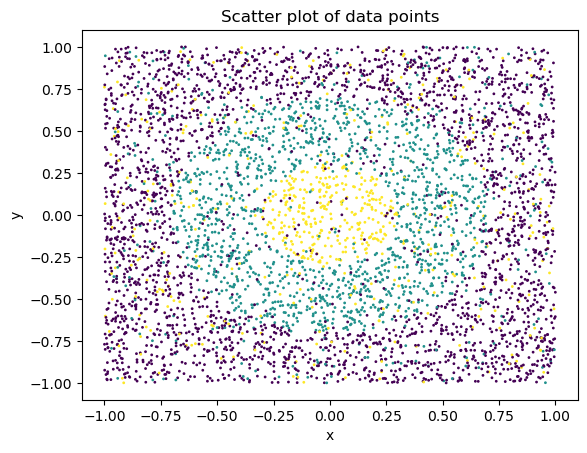

In [3]:
import matplotlib.pyplot as plt

plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=1)
plt.title('Scatter plot of data points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
import torch
import torch.nn.functional as F

data_torch = torch.tensor(data, dtype=torch.float32)
labels_torch = torch.tensor(labels, dtype=torch.long).reshape(-1)

# one-hot encoding으로 변환
labels_torch = F.one_hot(labels_torch)
print(labels_torch.size())

# 학습데이터를 7:3 정도로 train/validation으로 나누기
data_length = len(data_torch)
split_n = int(data_length * 0.7)
train_data = data_torch[:split_n]
train_labels = labels_torch[:split_n]
val_data = data_torch[split_n:]
val_labels = labels_torch[split_n:]


torch.Size([5000, 3])


In [5]:
g = torch.Generator().manual_seed(42)

# 배치로 데이터를 묶음(mini-batch)
def get_batch(x, y, batch_size):
  data_length = len(x)
  indices = torch.randint(0, data_length, (batch_size,), generator=g)

  x_batch = x[indices]
  y_batch = y[indices]
  return x_batch, y_batch

In [6]:
# cross entropy loss 함수
def custom_cross_entropy_loss(output, one_hot_labels):
  exp_output = torch.exp(output)
  total = torch.sum(exp_output, dim=1, keepdim=True)
  softmax_output = exp_output / total
  log_prob = -torch.log(softmax_output)
  nll = (log_prob * one_hot_labels).sum(dim=1)
  return torch.mean(nll)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim 

g.manual_seed(42)
torch.manual_seed(42)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    # nn.Sequential을 사용하여 여러 레이어를 연결
    self.seq_model = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, output_size)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.seq_model(x)
  


net = Net(2, 4, 3)
val_losses = []

# pytorch를 사용하면 더 정확하게 구현 가능
# loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for steps in range(100000):
  net.train()
  data_batch, label_batch = get_batch(train_data, train_labels, 256)
  output = net(data_batch)
  
  # loss = loss_fn(output, label_batch)
  loss = custom_cross_entropy_loss(output, label_batch)

  loss.backward()
  optimizer.step()

  optimizer.zero_grad()

  if steps % 1000 == 0:
    net.eval()
    output = net(val_data)

    # val_loss = loss_fn(output, val_labels)
    val_loss = custom_cross_entropy_loss(output, val_labels)
    val_losses.append(val_loss.item())
    print(f"{steps} val_loss: {val_loss.item()}")


0 val_loss: 1.0253418684005737
1000 val_loss: 0.9581136107444763
2000 val_loss: 0.9579643607139587
3000 val_loss: 0.9576233625411987
4000 val_loss: 0.9579432010650635
5000 val_loss: 0.9582386612892151
6000 val_loss: 0.957990288734436
7000 val_loss: 0.9578534364700317
8000 val_loss: 0.9576311111450195
9000 val_loss: 0.9578596353530884
10000 val_loss: 0.9577997922897339
11000 val_loss: 0.9579228758811951
12000 val_loss: 0.9579009413719177
13000 val_loss: 0.9576298594474792
14000 val_loss: 0.9575366973876953
15000 val_loss: 0.9579715132713318
16000 val_loss: 0.9583762288093567
17000 val_loss: 0.957856297492981
18000 val_loss: 0.9575903415679932
19000 val_loss: 0.9578694105148315
20000 val_loss: 0.9575796127319336
21000 val_loss: 0.9577245116233826
22000 val_loss: 0.9578596353530884
23000 val_loss: 0.9579363465309143
24000 val_loss: 0.9580650329589844
25000 val_loss: 0.957853376865387
26000 val_loss: 0.9583815336227417
27000 val_loss: 0.9579126238822937
28000 val_loss: 0.9577632546424866
2

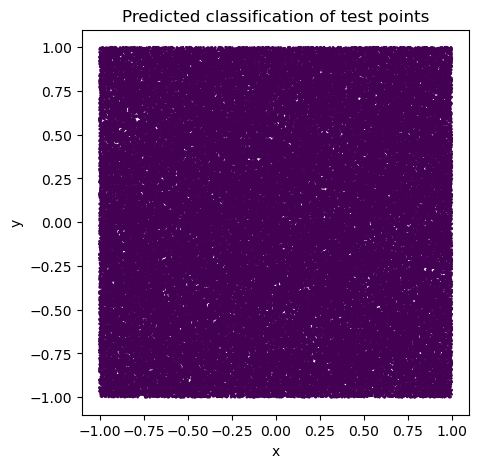

In [14]:
import numpy as np
import matplotlib.pyplot as plt

n_points_test = 100000
points_test = np.random.uniform(-1, 1, (n_points_test, 2))
points_test_torch = torch.from_numpy(points_test).float()

net.eval()
output_test = net(points_test_torch)

# softmax를 사용하여 확률로 변환
probability = torch.softmax(output_test, dim=1)
predictions = probability.argmax(dim=1)

prediction_np = predictions.numpy()

plt.figure(figsize=(5, 5))
plt.scatter(points_test[:, 0], points_test[:, 1], c=prediction_np, cmap='viridis', s=1)
plt.title('Predicted classification of test points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim 

g.manual_seed(42)
torch.manual_seed(42)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()

    # BatchNorm1d을 사용하여 배치 정규화 추가
    # norm을 사용시 bias=False로 설정해 메모리 절약
    self.seq_model = nn.Sequential(
      nn.Linear(input_size, hidden_size, bias=False),
      nn.BatchNorm1d(hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size, bias=False),
      nn.BatchNorm1d(hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size, bias=False),
      nn.BatchNorm1d(hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size, bias=False),
      nn.BatchNorm1d(hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size, bias=False),
      nn.BatchNorm1d(hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size, bias=False),
      nn.BatchNorm1d(hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size, bias=False),
      nn.BatchNorm1d(hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size, bias=False),
      nn.BatchNorm1d(hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size, bias=False),
      nn.BatchNorm1d(hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size, bias=False),
      nn.BatchNorm1d(hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size, bias=False),
      nn.BatchNorm1d(hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size, bias=False),
      nn.BatchNorm1d(hidden_size),
      nn.Tanh(),
      nn.Linear(hidden_size, hidden_size, bias=False),
      nn.BatchNorm1d(hidden_size),
      nn.Tanh(),
      nn.Dropout(),
      nn.Linear(hidden_size, output_size)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.seq_model(x)
  


net = Net(2, 4, 3)
val_losses = []

# pytorch를 사용하면 더 정확하게 구현 가능
# loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for steps in range(100000):
  net.train()
  data_batch, label_batch = get_batch(train_data, train_labels, 256)
  output = net(data_batch)
  
  # loss = loss_fn(output, label_batch)
  loss = custom_cross_entropy_loss(output, label_batch)

  loss.backward()
  optimizer.step()

  optimizer.zero_grad()

  if steps % 1000 == 0:
    net.eval()
    output = net(val_data)

    # val_loss = loss_fn(output, val_labels)
    val_loss = custom_cross_entropy_loss(output, val_labels)
    val_losses.append(val_loss.item())
    print(f"{steps} val_loss: {val_loss.item()}")


0 val_loss: 1.1842058897018433
1000 val_loss: 0.7116848230361938
2000 val_loss: 0.6795665621757507
3000 val_loss: 0.6876474618911743
4000 val_loss: 0.697157084941864
5000 val_loss: 0.6892025470733643
6000 val_loss: 0.6794235110282898
7000 val_loss: 0.6786462664604187
8000 val_loss: 0.6891446709632874
9000 val_loss: 0.6792526245117188
10000 val_loss: 0.6751644611358643
11000 val_loss: 0.6837379336357117
12000 val_loss: 0.6783944964408875
13000 val_loss: 0.6730244755744934
14000 val_loss: 0.6879973411560059
15000 val_loss: 0.6759614944458008
16000 val_loss: 0.6803774833679199
17000 val_loss: 0.6827788352966309
18000 val_loss: 0.6754536032676697
19000 val_loss: 0.6921275854110718
20000 val_loss: 0.6785395741462708
21000 val_loss: 0.6748934984207153
22000 val_loss: 0.678496241569519
23000 val_loss: 0.676618754863739
24000 val_loss: 0.6790988445281982
25000 val_loss: 0.6653547883033752
26000 val_loss: 0.664752185344696
27000 val_loss: 0.6438207626342773
28000 val_loss: 0.6282874941825867
29

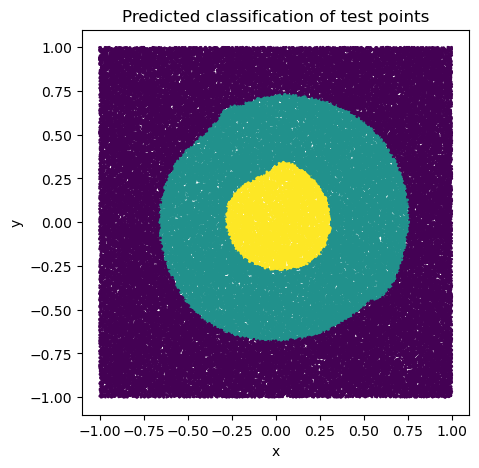

In [16]:
import numpy as np
import matplotlib.pyplot as plt

n_points_test = 100000
points_test = np.random.uniform(-1, 1, (n_points_test, 2))
points_test_torch = torch.from_numpy(points_test).float()

net.eval()
output_test = net(points_test_torch)

# softmax를 사용하여 확률로 변환
probability = torch.softmax(output_test, dim=1)
predictions = probability.argmax(dim=1)

prediction_np = predictions.numpy()

plt.figure(figsize=(5, 5))
plt.scatter(points_test[:, 0], points_test[:, 1], c=prediction_np, cmap='viridis', s=1)
plt.title('Predicted classification of test points')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
